In [ ]:
!pip install odc-stats==1.0.7 --upgrade

In [ ]:
!pip uninstall ndvi_tools -y

In [ ]:
!pip install ndvi_tools/

In [ ]:
import os
import json
import xarray as xr
import geopandas as gpd

import datacube
import matplotlib.pyplot as plt
from deafrica_tools.plotting import display_map
from deafrica_tools.dask import create_local_dask_cluster

from ndvi_tools.ndvi_climatology_plugin import NDVIClimatology

## Test plugin without odc-stats

In [ ]:
create_local_dask_cluster()

In [ ]:
dc = datacube.Datacube(app="Vegetation_anomalies")

In [ ]:
lat, lon = 5.7989, -2.489 #33.9801, -5.0561
buffer = 0.45
# Set the range of dates for the climatology
time_range = ('2009', '2020')
resolution = (-30, 30)

lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

In [ ]:
# display_map(x=lon_range, y=lat_range)

In [ ]:
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'resolution': resolution,
    'output_crs':'epsg:6933',
    'measurements':['red','nir','pixel_quality'],
    'group_by':'solar_day',
    'collection_category':'T1'
#     'dask_chunks':dask_chunks
}

### grab data so we can use the geobox parameter to mimic a 'task'

In [ ]:
task = dc.load(product=['ls5_sr','ls7_sr','ls8_sr'], dask_chunks={}, **query)

### grab lists of datatsets to mimic .db files

In [ ]:
dss = dc.find_datasets(product=['ls5_sr', 'ls7_sr', 'ls8_sr'], **query)

### set up an example config

In [ ]:
config = dict(
    resampling="bilinear",
    bands=["red", "nir"],
    mask_band="QA_PIXEL",
    harmonization_slope=0.988,
    harmonization_intercept= -0.015,
    mask_filters=[["opening", 5], ["dilation", 5]],
    work_chunks= dict(x=2000, y=2000),
    flags_ls57=dict(cloud="high_confidence", cloud_shadow="high_confidence"),
    flags_ls8=dict(
        cloud="high_confidence",
        cloud_shadow="high_confidence",
        cirrus="high_confidence",
    ),
)

### Run the plugin code

In [ ]:
x=NDVIClimatology(**config)
ndvi = x.input_data(dss, task.geobox)
result = x.reduce(ndvi)#.compute()
print(result)

In [ ]:
%%time
result = result.compute()

### Plot

In [ ]:
fig,ax=plt.subplots(1,12, sharex=True, sharey=True, figsize=(30,4))
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    result['mean_'+j].plot.imshow(ax=ax[i], add_colorbar=False, vmin=0, vmax=0.9)
    ax[i].set_title(j)

In [ ]:
fig,ax=plt.subplots(1,12, sharex=True, sharey=True, figsize=(30,4))
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    result['stddev_'+j].plot.imshow(ax=ax[i], vmin=0,vmax=0.4, add_colorbar=False)
    ax[i].set_title(j)

In [ ]:
fig,ax=plt.subplots(1,12, sharex=True, sharey=True, figsize=(30,4))
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    result['count_'+j].where(result['count_'+j]>0).plot.imshow(ax=ax[i], vmin=0, vmax=50)
    ax[i].set_title(j)

In [ ]:
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    print(j, result['mean_'+j].mean().values)

In [ ]:
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    print(j, result['stddev_'+j].mean().values)

In [ ]:
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    print(j, result['count_'+j].mean().values)

# Test plugin with odc-stats

In [ ]:
!pip uninstall ndvi_tools -y

In [ ]:
!pip install ndvi_tools/

In [1]:
import os
import json
import xarray as xr
import geopandas as gpd
from odc.stats.tasks import TaskReader
from odc.stats.model import OutputProduct

### Generate tasks etc

In [ ]:
%%time
!odc-stats save-tasks --frequency annual --grid africa_30 --temporal-range 1984--P36Y ls5_sr-ls7_sr-ls8_sr --frequency all --dataset-filter '{"collection_category": "T1"}'

In [ ]:
# os.system("cm-task --task-csv=ls5_sr-ls7_sr-ls8_sr_2011--P5Y.csv "\
#           "--geojson=../testing/data/testing_extent.geojson "\
#           "--outfile=aez.csv "\
#           "--grid=africa_30 " \
#           "--sqs=deafrica-dev-eks-stats-ndvi-clim "\
#           "--db=ls5_sr-ls7_sr-ls8_sr_2011--P5Y.db "\
#          )

### Enter the X and Y Tile ID of the tile you want to run

Use the geojson to select a tile id

In [2]:
tile_x = '178' #x173y118
tile_y = '084'  	

t=[int(tile_x), int(tile_y)]

### Extract the tasks object for that tile

In [3]:
name, version = 'ndvi_climatology_ls', '1-0-0'
op = OutputProduct(
            name='ndvi_climatology_ls',
            version='1-0-0',
            short_name='ndvi_climatology_ls',
            location=f"s3://dummy-bucket/{name}/{version}",
            properties={"odc:file_format": "GeoTIFF"},
            measurements=['red']
        )

taskdb = TaskReader('ndvi_climatology_ls_1984--P36Y.db', product=op)
task = taskdb.load_task(('1984--P37Y', t[0], t[1]))

### Optionally export tile geojson to view

In [4]:
with open('task_tile_check.geojson', 'w') as fh:
    json.dump(task.geobox.extent.to_crs('epsg:4326').json, fh, indent=2)

### Find the index of the tile we want to run

In [5]:
tile_index_to_run = []
all_tiles = list(taskdb.all_tiles)
for i, index in zip(all_tiles, range(0, len(all_tiles))):
    if (i[1]==t[0]) & (i[2]==t[1]):
        tile_index_to_run.append(index)
        print(index)

614


### Try running odc-stats using the config yaml and external plugin

In [6]:
%%time
os.system("odc-stats run "\
          "ndvi_climatology_ls_1984--P36Y.db "\
          "--config=///home/jovyan/git/ndvi-anomalies/production/ndvi_tools/config/ndvi_climatology.yaml "\
          "--resolution=30 "\
          "--threads=60 "\
          "--memory-limit=460Gi "\
          "--location=file:///home/jovyan/git/ndvi-anomalies/production/{product}/{version}/ "+str(tile_index_to_run[0])
         )

[2021-12-23 10:56:28,063] {_cli_run.py:139} INFO - Config overrides: {'filedb': 'ndvi_climatology_ls_1984--P36Y.db', 'threads': 60, 'memory_limit': '460Gi', 'output_location': 'file:///home/jovyan/git/ndvi-anomalies/production/{product}/{version}/'}
[2021-12-23 10:56:28,063] {_cli_run.py:158} INFO - Using this config: TaskRunnerConfig(filedb='ndvi_climatology_ls_1984--P36Y.db', aws_unsigned=True, plugin='ndvi_tools.ndvi_climatology_plugin.NDVIClimatology', plugin_config={'resampling': 'bilinear', 'bands': ['red', 'nir'], 'mask_band': 'QA_PIXEL', 'harmonization_slope': 0.988, 'harmonization_intercept': -0.015, 'mask_filters': [['opening', 5], ['dilation', 5]], 'flags_ls57': {'cloud': 'high_confidence', 'cloud_shadow': 'high_confidence'}, 'flags_ls8': {'cloud': 'high_confidence', 'cloud_shadow': 'high_confidence', 'cirrus': 'high_confidence'}}, product={'name': 'ndvi_climatology_ls', 'short_name': 'ndvi_climatology_ls', 'version': '1.0.0', 'collections_site': 'explorer.digitalearth.afric

CPLReleaseMutex: Error = 1 (Operation not permitted)


[2021-12-23 11:06:30,049] {proc.py:246} INFO - Finished processing of x178/y084/1984--P37Y
[2021-12-23 11:06:30,050] {_cli_run.py:188} INFO - Finished task #1: x178/y084/1984--P37Y 6528aba4-8a81-529f-a46b-5cda5370f07b
[2021-12-23 11:06:30,050] {_cli_run.py:193} INFO - T:1, OK:1, S:0, E:0
[2021-12-23 11:06:30,054] {_cli_run.py:195} INFO - Completed processing 1 tasks, OK:1, S:0, E:0
[2021-12-23 11:06:30,054] {_cli_run.py:199} INFO - Shutting down Dask cluster
[2021-12-23 11:06:30,066] {_cli_run.py:201} INFO - Calling sys.exit(0)


/env/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/env/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/env/lib/python3.8/site-packages/xarray/core/indexing.py:122

[2021-12-23 11:06:37,901] {base_events.py:1707} ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-200' coro=<RequestHandler._execute() running at /env/lib/python3.8/site-packages/tornado/web.py:1704> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7efd5889fdc0>()]> cb=[_HandlerDelegate.execute.<locals>.<lambda>() at /env/lib/python3.8/site-packages/tornado/web.py:2326]>
[2021-12-23 11:06:37,944] {base_events.py:1707} ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-121' coro=<RequestHandler._execute() running at /env/lib/python3.8/site-packages/tornado/web.py:1704> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7efd36089190>()]> cb=[_HandlerDelegate.execute.<locals>.<lambda>() at /env/lib/python3.8/site-packages/tornado/web.py:2326]>
CPU times: user 13 ms, sys: 13.9 ms, total: 26.9 ms
Wall time: 10min 13s


0

In [ ]:
# !odc-stats run ls7_sr-ls8_sr_2014--P2Y.db --config=ndvi_climatology.yaml --resolution=80 --threads=4 --memory-limit=29Gi --location=file:///home/jovyan/git/deafrica-sandbox-notebooks/frica-sandbox-notebooks/HLS/{product}/{version} 1202

### Plot results

In [11]:
mon= 'jan'

<xarray.DataArray (y: 3200, x: 3200)>
[10240000 values with dtype=float32]
Coordinates:
    band     int64 1
  * y        (y) float64 7.68e+05 7.68e+05 7.679e+05 ... 6.72e+05 6.72e+05
  * x        (x) float64 -2.88e+05 -2.88e+05 -2.879e+05 ... -1.92e+05 -1.92e+05
Attributes:
    transform:      (30.0, 0.0, -288000.0, 0.0, -30.0, 768000.0)
    crs:            +init=epsg:6933
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


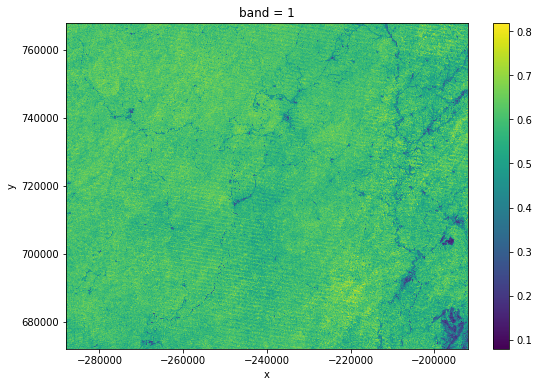

In [12]:
a= 'x'+str(t[0])
b='y0'+str(t[1])

mean=xr.open_rasterio('ndvi_climatology_ls/1-0-0/'+a+'/'+b+'/1984--P37Y/ndvi_climatology_ls_'+a+b+'_1984--P37Y_mean_'+mon+'.tif').squeeze()
print(mean)
mean.squeeze().plot.imshow(size=6);

<xarray.DataArray (y: 3200, x: 3200)>
[10240000 values with dtype=float32]
Coordinates:
    band     int64 1
  * y        (y) float64 7.68e+05 7.68e+05 7.679e+05 ... 6.72e+05 6.72e+05
  * x        (x) float64 -2.88e+05 -2.88e+05 -2.879e+05 ... -1.92e+05 -1.92e+05
Attributes:
    transform:      (30.0, 0.0, -288000.0, 0.0, -30.0, 768000.0)
    crs:            +init=epsg:6933
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


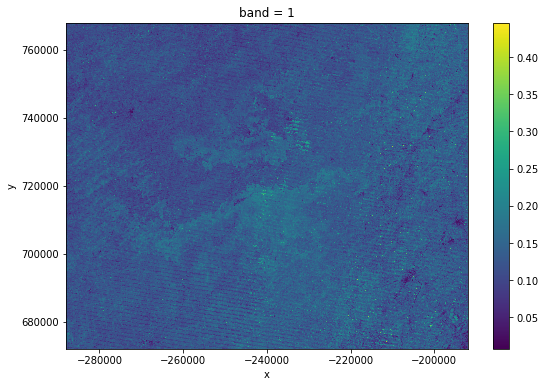

In [13]:
std=xr.open_rasterio('ndvi_climatology_ls/1-0-0/'+a+'/'+b+'/1984--P37Y/ndvi_climatology_ls_'+a+b+'_1984--P37Y_stddev_'+mon+'.tif').squeeze()
print(std)
std.squeeze().plot.imshow(size=6);

<xarray.DataArray (y: 3200, x: 3200)>
[10240000 values with dtype=int8]
Coordinates:
    band     int64 1
  * y        (y) float64 7.68e+05 7.68e+05 7.679e+05 ... 6.72e+05 6.72e+05
  * x        (x) float64 -2.88e+05 -2.88e+05 -2.879e+05 ... -1.92e+05 -1.92e+05
Attributes:
    transform:      (30.0, 0.0, -288000.0, 0.0, -30.0, 768000.0)
    crs:            +init=epsg:6933
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


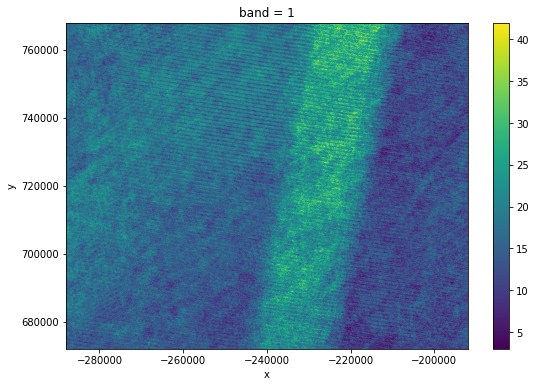

In [14]:
count=xr.open_rasterio('ndvi_climatology_ls/1-0-0/'+a+'/'+b+'/1984--P37Y/ndvi_climatology_ls_'+a+b+'_1984--P37Y_count_'+mon+'.tif').squeeze()
print(count)
count.where(count > 0).squeeze().plot.imshow(size=6);

### remove results folder

In [ ]:
!rm -r -f ndvi_climatology_ls/

## Sync folder from s3

In [ ]:
!aws s3 sync s3://deafrica-data-dev-af/ndvi_climatology_ls/dbs dbs  --no-sign-request

In [ ]:
# !aws s3 sync s3://deafrica-data-staging-af/crop_mask_southern/ crop_mask_southern --no-sign-request
# !aws s3 sync s3://deafrica-services/crop_mask_northern/ crop_mask_northern --no-sign-request --dryrun

## Remove files from AWS

In [ ]:
!aws s3 rm --recursive s3://deafrica-data-dev-af/crop_mask_southern --dryrun

## plotting

In [ ]:
mon= 'aug'
a= 'x178'
b='y084'


In [ ]:
mean=xr.open_rasterio('ndvi_climatology_ls/1-0-0/'+a+'/'+b+'/1984--P37Y/ndvi_climatology_ls_'+a+b+'_1984--P37Y_mean_'+mon+'.tif').squeeze()
print(mean.mean())
mean.squeeze().plot.imshow(size=6, vmax=1.0, vmin=0.0);

In [ ]:
std=xr.open_rasterio('ndvi_climatology_ls/1-0-0/'+a+'/'+b+'/1984--P37Y/ndvi_climatology_ls_'+a+b+'_1984--P37Y_stddev_'+mon+'.tif').squeeze()
std.squeeze().plot.imshow(size=6);

In [ ]:
# result.count_aug.mean()
count.mean()

In [ ]:
count=xr.open_rasterio('ndvi_climatology_ls/1-0-0/'+a+'/'+b+'/1984--P37Y/ndvi_climatology_ls_'+a+b+'_1984--P37Y_count_'+mon+'.tif').squeeze()
count.squeeze().plot.imshow(size=6);

In [ ]:
result.mean_jan.plot(size=6, vmax=1.0, vmin=0.0);

In [ ]:
result.count_aug.where(result.count_aug>0).plot(size=6);